<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220918.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [1]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
from datetime import datetime, date, time, timezone, timedelta 
import os
import re
from functools import reduce
from collections import defaultdict, ChainMap, Counter

# customer analysis

In [2]:
os.listdir()

['.config',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'online_retail_II.xlsx',
 'test.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'ecommerce-data.csv',
 'sample_data']

In [3]:
df = pd.read_csv('KPMG_VI_New_raw_data_update_final.csv')
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,25-02-2017,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,21-05-2017,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,16-10-2017,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,31-08-2017,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,01-10-2017,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [4]:
df = df[df.order_status == 'Approved']
df.transaction_date = pd.to_datetime(df.transaction_date)
df['date'] = df.transaction_date.to_numpy().astype('datetime64[D]')
df['month'] = df.transaction_date.to_numpy().astype('datetime64[M]')
df['week'] = df['date'] - df['date'].dt.weekday.astype('timedelta64[D]')
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,date,month,week
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0,2017-02-25,2017-02-01,2017-02-20
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0,2017-05-21,2017-05-01,2017-05-15
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0,2017-10-16,2017-10-01,2017-10-16
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0,2017-08-31,2017-08-01,2017-08-28
4,5,78,787,2017-01-10,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0,2017-01-10,2017-01-01,2017-01-09


In [18]:
cnt = df.groupby(['month', 'online_order', 'brand']).agg({'standard_cost':'sum','customer_id':'count'}).reset_index()
cnt = cnt.rename(columns = {'standard_cost':'rev', 'customer_id':'cnt'})
#cnt['month'] = cnt['month'].astype(str)
cnt['ratio'] = cnt.groupby(['month','brand'])['rev'].apply(lambda x : round(x/x.sum()*100,2))
cnt.head()

,month,online_order,brand,rev,cnt,ratio
0,2017-01-01,False,Giant Bicycles,108386.530000,150,53.63
1,2017-01-01,False,Norco Bicycles,62346.639988,106,44.26
2,2017-01-01,False,OHM Cycles,45936.470000,106,37.44
3,2017-01-01,False,Solex,80042.880000,163,44.86
4,2017-01-01,False,Trek Bicycles,66483.710000,119,52.02


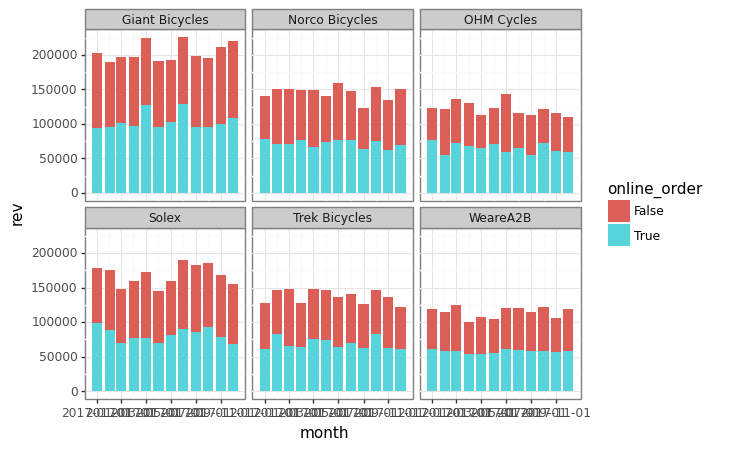

<ggplot: (8793847561845)>

In [19]:
(
    ggplot(cnt, aes('month', 'rev', fill = 'online_order')) +
    gg.geom_col() +
    gg.facet_wrap('~brand') +
    gg.theme_bw()
)

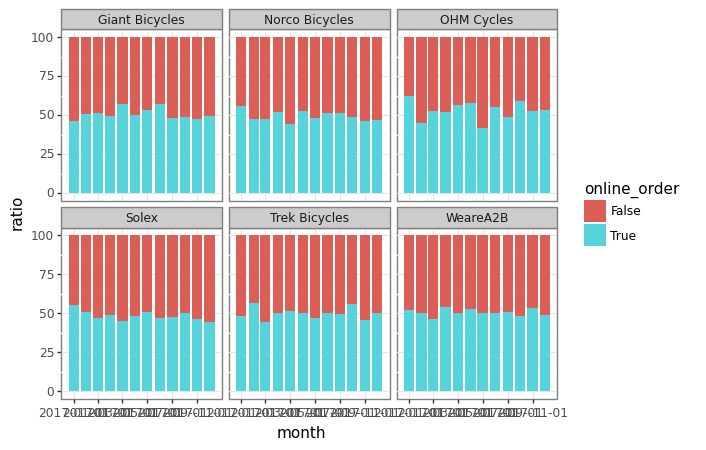

<ggplot: (8793847348629)>

In [20]:
(
    ggplot(cnt, aes('month', 'ratio', fill = 'online_order')) +
    gg.geom_col() +
    gg.facet_wrap('~brand') +
    gg.theme_bw()
)

In [22]:
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,date,month,week
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0,2017-02-25,2017-02-01,2017-02-20
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0,2017-05-21,2017-05-01,2017-05-15
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0,2017-10-16,2017-10-01,2017-10-16
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0,2017-08-31,2017-08-01,2017-08-28
4,5,78,787,2017-01-10,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0,2017-01-10,2017-01-01,2017-01-09


In [33]:
df[['brand', 'online_order', 'product_line', 'product_class', 'product_size']].value_counts().reset_index().sort_values(['brand', 'online_order'])

,brand,online_order,product_line,product_class,product_size,0
6,Giant Bicycles,False,Standard,medium,medium,400
8,Giant Bicycles,False,Standard,medium,large,382
17,Giant Bicycles,False,Standard,high,medium,262
38,Giant Bicycles,False,Road,medium,medium,181
69,Giant Bicycles,False,Touring,medium,large,94
...,...,...,...,...,...,...
22,WeareA2B,True,Touring,medium,large,226
36,WeareA2B,True,Standard,medium,small,183
61,WeareA2B,True,Touring,medium,medium,101
88,WeareA2B,True,Standard,low,medium,83


In [36]:
cnt2 = df[['brand', 'online_order', 'product_line', 'product_class', 'list_price', 'standard_cost']].value_counts().reset_index().sort_values(['brand', 'online_order'])
cnt2.head()

,brand,online_order,product_line,product_class,list_price,standard_cost,0
2,Giant Bicycles,False,Standard,medium,1403.50,954.82,199
22,Giant Bicycles,False,Standard,high,1129.13,677.48,108
28,Giant Bicycles,False,Standard,medium,1765.30,709.48,106
39,Giant Bicycles,False,Standard,medium,230.91,173.18,104
51,Giant Bicycles,False,Road,medium,792.90,594.68,101


In [58]:
cnt2.columns = ['cnt' if len(str(a)) == 1 else a for a in cnt2.columns]
cnt2 = cnt2.assign(
    ratio = round(cnt2['standard_cost']/cnt2['list_price']*100,2),
    online_ratio = cnt2.groupby(['brand', 'product_line', 'product_class'])['cnt'].apply(lambda x : round(x/x.sum()*100,2))
    )
cnt2.head()

,brand,online_order,product_line,product_class,list_price,standard_cost,cnt,ratio,online_ratio
2,Giant Bicycles,False,Standard,medium,1403.50,954.82,199,68.03,11.59
22,Giant Bicycles,False,Standard,high,1129.13,677.48,108,60.00,14.25
28,Giant Bicycles,False,Standard,medium,1765.30,709.48,106,40.19,6.17
39,Giant Bicycles,False,Standard,medium,230.91,173.18,104,75.00,6.06
51,Giant Bicycles,False,Road,medium,792.90,594.68,101,75.00,26.79


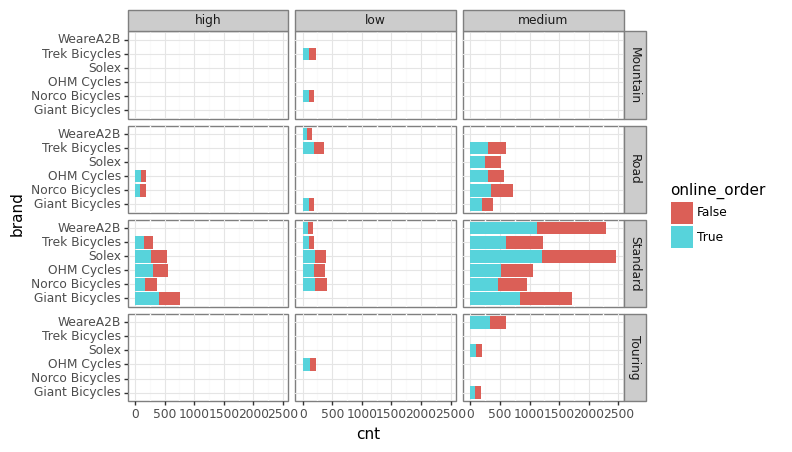

<ggplot: (8793846640561)>

In [61]:
(
    ggplot(cnt2, aes('brand', 'cnt', fill = 'online_order')) +
    gg.geom_col() +
    gg.facet_grid('product_line ~ product_class') +
    gg.theme_bw() +
    gg.coord_flip()
)

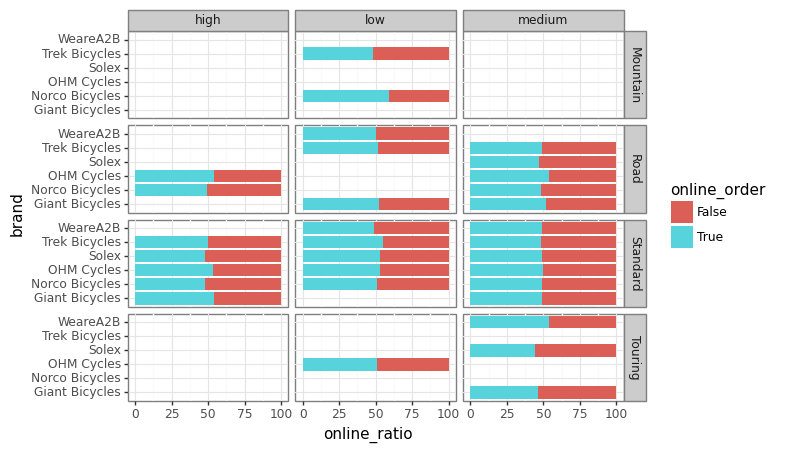

<ggplot: (8793847600645)>

In [62]:
(
    ggplot(cnt2, aes('brand', 'online_ratio', fill = 'online_order')) +
    gg.geom_col() +
    gg.facet_grid('product_line ~ product_class') +
    gg.theme_bw() +
    gg.coord_flip()
)

# iterator

In [69]:
mat = [list('ABC'), list('DEF'), list('GHI')]
a = {letters : [r, c] for r, rows in enumerate(mat) for c, letters in enumerate(rows)}
a

{'A': [0, 0],
 'B': [0, 1],
 'C': [0, 2],
 'D': [1, 0],
 'E': [1, 1],
 'F': [1, 2],
 'G': [2, 0],
 'H': [2, 1],
 'I': [2, 2]}

In [72]:
arr1 = np.empty([3,3], dtype = 'S10')
arr2 = np.empty([3,3], dtype = 'object')
for k, v in a.items() :
  arr1[v[0],v[1]] = k
  arr2[v[0],v[1]] = k

print(arr1)
print(arr2)

[[b'A' b'B' b'C']
 [b'D' b'E' b'F']
 [b'G' b'H' b'I']]
[['A' 'B' 'C']
 ['D' 'E' 'F']
 ['G' 'H' 'I']]


In [79]:
import time

In [90]:
def arthor_with_name(name) :
  def arthor(func) :
    def wrapper(*args, **kwargs) :
      return name + '\n' + func(*args, **kwargs)
    return wrapper 
  return arthor 

def get_time(func) :
  def wrapper(*args, **kwargs) :
    s = time.time()
    func(*args, **kwargs)
    e = time.time()
    res = e - s
    print(f'{res:.10f}')    
  return wrapper

@get_time
@arthor_with_name('kim')
def get_title(title) :
  return title

In [91]:
print(get_title('내 마지막 얘기'))

0.0000038147
None
